In [1]:
import os
import io
import pickle
from glob import glob
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

import wandb
from wandb.lightgbm import wandb_callback, log_summary
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Config

In [2]:
EXP_NAME = "exp005"
# EXP_NAME = "debug"

class configs:
    EXP_CATEGORY = "baseline"
    EXP_NAME = EXP_NAME
    OUTPUT_DIR = os.path.join("/workspace", "working", EXP_NAME)
    
    INPUT_DIR = os.path.join("/workspace", "input", "atmaCup15_dataset")
    # TRAIN_CSV = "/workspace/working/svd_filtering_oof/train_addSVD.csv"
    TRAIN_CSV = "/workspace/working/svdpp/train_addSVDpp.csv"
    ANIME_CSV = os.path.join(INPUT_DIR, "anime.csv")
    # TEST_CSV = "/workspace/working/svd_filtering_oof/test_addSVD.csv"
    TEST_CSV = "/workspace/working/svdpp/test_addSVDpp.csv"
    SAMPLE_SUB_CSV = os.path.join(INPUT_DIR, "sample_submission.csv")
    target_colname = "score"
    
    COMPETITION = "atmaCup15"
    USER_NAME = "taro"
    wandb_available = True
    
    # train
    num_boost_round = 1000
    early_stopping_rounds = 200
    verbose_eval = 100
    FOLDS = [0, 1, 2, 3, 4]

if EXP_NAME is "debug":
    configs.wandb_available = False
    configs.num_boost_round = 10
else:
    os.makedirs(configs.OUTPUT_DIR)

In [3]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    "objective": "rmse", 
    'metric': 'rmse',
    "n_estimators": 10000, 
    "learning_rate": .01,
    "verbosity": -1, 
    "random_state": 510,
}
configs.params = params

# Utils

In [4]:
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


In [5]:
def root_mean_squared_error(y_true, y_pred):
    """mean_squared_error の root (0.5乗)"""
    return mean_squared_error(y_true, y_pred) ** .5

## utils for data

In [6]:
def merge_by_anime_id(left_df, right_df):
    return pd.merge(left_df["anime_id"], right_df, on="anime_id", how="left").drop(columns=["anime_id"])

In [7]:
def merge_by_user_id(left_df, right_df):
    return pd.merge(left_df["user_id"], right_df, on="user_id", how="left").drop(columns=["user_id"])

## features func

In [8]:
def create_anime_numeric_feature(input_df: pd.DataFrame):
    """input_dfは train or test.csv のデータが入ってくることを想定しています."""
    
    use_columns = [
        "members", 
    ]
    
    return merge_by_anime_id(input_df, anime_df)[use_columns]

#### label encoding

In [9]:
def create_anime_genres_label_encoding(input_df: pd.DataFrame):
    target_col = "genres"
    encoder = LabelEncoder()
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_le": encoder.fit_transform(anime_df[target_col].fillna("nan"))
    })
    return merge_by_anime_id(input_df, encoded_df)

In [10]:
def create_anime_source_label_encoding(input_df: pd.DataFrame):
    target_col = "source"
    encoder = LabelEncoder()
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_le": encoder.fit_transform(anime_df[target_col].fillna("nan"))
    })
    return merge_by_anime_id(input_df, encoded_df)

#### count encoding

In [11]:
# animeのtypeをカウントエンコーディング
def create_anime_type_count_encoding(input_df: pd.DataFrame):
    target_col = "type"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [12]:
def create_anime_studios_count_encoding(input_df: pd.DataFrame):
    target_col = "studios"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [13]:
def create_anime_producers_count_encoding(input_df: pd.DataFrame):
    target_col = "producers"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [14]:
def create_anime_animeid_count_encoding(input_df: pd.DataFrame):
    target_col = "anime_id"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [15]:
def create_anime_source_count_encoding(input_df: pd.DataFrame):
    target_col = "source"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

#### groupby encoding

#### one-hot encoding

In [16]:
# animeのtypeをone-hotエンコーディング
def create_anime_type_one_hot_encoding(input_df: pd.DataFrame):
    # 対象の列のユニーク集合を取る
    target_colname = "type"
    target_series = anime_df[target_colname]
    unique_values = target_series.unique()

    # ユニークな値ごとに列を作る
    out_df = pd.DataFrame()
    for value in unique_values:
        is_value = target_series == value
        if value == "Unknown":
            out_df["Unknown_type"] = is_value.astype(int)
        else:
            out_df[value] = is_value.astype(int)
    
    out_df["anime_id"] = anime_df["anime_id"]
    return merge_by_anime_id(input_df, out_df)

In [17]:
# animeのtypeをone-hotエンコーディング
def create_anime_rating_one_hot_encoding(input_df: pd.DataFrame):
    # 対象の列のユニーク集合を取る
    target_colname = "rating"
    target_series = anime_df[target_colname]
    unique_values = target_series.unique()

    # ユニークな値ごとに列を作る
    out_df = pd.DataFrame()
    for value in unique_values:
        is_value = target_series == value
        if value == "Unknown":
            out_df["Unknown_rate"] = is_value.astype(int)
        else:
            out_df[value] = is_value.astype(int)
    
    out_df["anime_id"] = anime_df["anime_id"]
    return merge_by_anime_id(input_df, out_df)

#### add feature

In [18]:
# animeのtypeをone-hotエンコーディング
def create_anime_start_end_date(input_df: pd.DataFrame):
    # 対象の列のユニーク集合を取る
    target_colname = ["anime_id", "start_date", "end_date"]
    anime_df_ = anime_df[target_colname].copy()
    
    anime_df_["start_date"] = pd.to_datetime(anime_df_["start_date"])
    anime_df_["start_date_year"] = anime_df_["start_date"].dt.year
    anime_df_["start_date_month"] = anime_df_["start_date"].dt.month
    anime_df_["start_date_day"] = anime_df_["start_date"].dt.day
    
    anime_df_["end_date"] = pd.to_datetime(anime_df_["end_date"])
    anime_df_["end_date_year"] = anime_df_["end_date"].dt.year
    anime_df_["end_date_month"] = anime_df_["end_date"].dt.month
    anime_df_["end_date_day"] = anime_df_["end_date"].dt.day
    
    out_df = anime_df_[["anime_id", 
                        "start_date_year", "start_date_month", "start_date_day",
                        "end_date_year", "end_date_month", "end_date_day",
                      ]]
    return merge_by_anime_id(input_df, out_df)

In [19]:
# 上で定義した関数をまとめて実行
def create_feature(input_df, config_):
    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        # add date
        create_anime_start_end_date,
        # create numeric
        create_anime_numeric_feature,
        # label encoding
        create_anime_genres_label_encoding, 
        create_anime_source_label_encoding, 
        # count encoding
        create_anime_type_count_encoding,
        create_anime_studios_count_encoding,
        create_anime_producers_count_encoding,
        create_anime_animeid_count_encoding, 
        # one-hot encoding
        create_anime_type_one_hot_encoding,
        create_anime_rating_one_hot_encoding,
        # group encoding
    ]
    
    out_df = pd.DataFrame()
    func_name_list = []
    for func in functions:
        func_name = str(func.__name__)
        func_name_list.append(func_name)
        with Timer(prefix=f"create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)
    
    config_.preprocess_funcs = func_name_list
    return out_df, config_

#### convert date in anime

In [20]:
def convert_startdate(row):
    if " to " in row.aired:
        start_date, _ = row.aired.split(" to ")
        return pd.to_datetime(start_date)
    elif row.aired == "Unknown":
        return datetime.datetime.strptime("1900-01-01", '%Y-%m-%d')
    else:
        start_date = row.aired
        return pd.to_datetime(start_date)

def convert_enddate(row):
    if " to " in row.aired:
        _, end_date = row.aired.split(" to ")
        if end_date == "?":
            return datetime.datetime.strptime("2262-01-01", '%Y-%m-%d')
        else:
            return pd.to_datetime(end_date)
    elif row.aired == "Unknown":
        return datetime.datetime.strptime("2262-01-01", '%Y-%m-%d')
    else:
        end_date = row.aired
        return pd.to_datetime(end_date)

# train func

In [21]:
def save_model(model, fold):
    save_path = os.path.join(configs.OUTPUT_DIR, f"model_fold{fold}.pkl")
    # pickle.dump(model, save_path)
    with open(save_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"SAVED: {save_path}")

In [22]:
def fit_lgbm(df, configs):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    models = []
    evals_results_list = [] 
    n_records = len(df)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)
    target = []
    for fold in configs.FOLDS: 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        train_df_ = df[df["fold"] != fold].reset_index(drop=True)
        valid_df_ = df[df["fold"] == fold].reset_index(drop=True)
        idx_valid = df[df["fold"] == fold].index.values
        
        x_train = train_df_.drop(columns=[configs.target_colname, "fold"])
        # print(x_train.columns)
        y_train = train_df_[configs.target_colname]
        x_valid = valid_df_.drop(columns=[configs.target_colname, "fold"])
        y_valid = valid_df_[configs.target_colname]
        target.extend(y_valid)
        
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

        lgb_result = {}
        with Timer(prefix="fit fold={} ".format(fold)):
            if configs.wandb_available:
                clf = lgb.train(configs.params,
                                lgb_train,
                                valid_sets=[lgb_train, lgb_eval],  
                                valid_names=[f"validation_{fold}"],
                                num_boost_round=configs.num_boost_round,
                                early_stopping_rounds=configs.early_stopping_rounds,
                                evals_result=lgb_result,
                                verbose_eval=configs.verbose_eval,
                                callbacks=[wandb_callback()])
                evals_results_list.append(lgb_result)
                log_summary(clf, save_model_checkpoint=False)

            else:
                clf = lgb.train(configs.params,
                                lgb_train,
                                valid_sets=[lgb_train, lgb_eval],  
                                valid_names=[f"validation_{fold}"],
                                num_boost_round=configs.num_boost_round,
                                early_stopping_rounds=configs.early_stopping_rounds,
                                evals_result=lgb_result,
                                verbose_eval=configs.verbose_eval,
                                )
                evals_results_list.append(lgb_result)
        
        # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
        # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        save_model(clf, fold)
        score = root_mean_squared_error(y_valid, pred_i)
        print(f" - fold{fold} - {score:.4f}")
        if configs.wandb_available:
            wandb.log({"fold": fold, "rmse": score})

    score = root_mean_squared_error(target, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return oof_pred, target, models, evals_results_list

# Load data

In [23]:
anime_df = pd.read_csv(configs.ANIME_CSV)

train_df = pd.read_csv(configs.TRAIN_CSV)
test_df = pd.read_csv(configs.TEST_CSV)

In [24]:
anime_df["start_date"] = anime_df.apply(convert_startdate, axis=1)

In [25]:
anime_df["end_date"] = anime_df.apply(convert_enddate, axis=1)

## preprocess
- CountEncoding
- OneHotEncoding

In [26]:
# 実行して train / test 用の特徴量を作ります.

with Timer(prefix="train..."):
    train_feat_df, configs = create_feature(train_df, configs)

with Timer(prefix="test..."):
    test_feat_df, configs = create_feature(test_df, configs)

# X = train_feat_df.values
# print(train_feat_df.columns)
# y = train_df["score"].values


create create_anime_start_end_date 0.023[s]
create create_anime_numeric_feature 0.054[s]
create create_anime_genres_label_encoding 0.013[s]
create create_anime_source_label_encoding 0.011[s]
create create_anime_type_count_encoding 0.011[s]
create create_anime_studios_count_encoding 0.014[s]
create create_anime_producers_count_encoding 0.014[s]
create create_anime_animeid_count_encoding 0.011[s]
create create_anime_type_one_hot_encoding 0.016[s]
create create_anime_rating_one_hot_encoding 0.017[s]
train... 0.204[s]
create create_anime_start_end_date 0.017[s]
create create_anime_numeric_feature 0.044[s]
create create_anime_genres_label_encoding 0.012[s]
create create_anime_source_label_encoding 0.010[s]
create create_anime_type_count_encoding 0.011[s]
create create_anime_studios_count_encoding 0.011[s]
create create_anime_producers_count_encoding 0.011[s]
create create_anime_animeid_count_encoding 0.011[s]
create create_anime_type_one_hot_encoding 0.015[s]
create create_anime_rating_one_

In [27]:
input_df = pd.concat([train_df, train_feat_df], axis=1)
input_df = input_df.drop(["user_id", "anime_id"], axis=1)

In [28]:
input_df.columns

Index(['score', 'fold', 'svd', 'start_date_year', 'start_date_month',
       'start_date_day', 'end_date_year', 'end_date_month', 'end_date_day',
       'members', 'genres_le', 'source_le', 'type_count', 'studios_count',
       'producers_count', 'anime_id_count', 'TV', 'Special', 'Movie',
       'Unknown_type', 'ONA', 'OVA', 'Music', 'PG-13 - Teens 13 or older',
       'R+ - Mild Nudity', 'R - 17+ (violence & profanity)', 'G - All Ages',
       'PG - Children', 'Rx - Hentai', 'Unknown_rate'],
      dtype='object')

# Train

In [29]:
if configs.wandb_available:
   WANDB_CONFIG = {'competition': "atma15", '_wandb_kernel': "taro"}
   os.environ["WANDB_SILENT"] = "true"
   # config_dict = dict(vars(configs))
   wandb.init(project=WANDB_CONFIG["competition"],
               # config=config_dict,
               group=configs.EXP_CATEGORY, 
               name=configs.EXP_NAME,
               reinit=True,
               save_code=True)
   print("wandb initialized")
else:
   print("wandb logging is not available")

wandb initialized


In [30]:
oof, target, models, evals_results = fit_lgbm(input_df, configs)

Training until validation scores don't improve for 200 rounds
[100]	validation_0's rmse: 1.2422	valid_1's rmse: 1.24844
[200]	validation_0's rmse: 1.19012	valid_1's rmse: 1.19952
[300]	validation_0's rmse: 1.18042	valid_1's rmse: 1.19277
[400]	validation_0's rmse: 1.17694	valid_1's rmse: 1.192
[500]	validation_0's rmse: 1.17462	valid_1's rmse: 1.19204
[600]	validation_0's rmse: 1.17284	valid_1's rmse: 1.19252
Early stopping, best iteration is:
[456]	validation_0's rmse: 1.17556	valid_1's rmse: 1.19194
fit fold=0  10.295[s]
SAVED: /workspace/working/exp005/model_fold0.pkl
 - fold0 - 1.1919
Training until validation scores don't improve for 200 rounds
[100]	validation_1's rmse: 1.24283	valid_1's rmse: 1.24529
[200]	validation_1's rmse: 1.19079	valid_1's rmse: 1.19605
[300]	validation_1's rmse: 1.18124	valid_1's rmse: 1.18905
[400]	validation_1's rmse: 1.17792	valid_1's rmse: 1.18815
[500]	validation_1's rmse: 1.17566	valid_1's rmse: 1.188
[600]	validation_1's rmse: 1.17395	valid_1's rmse

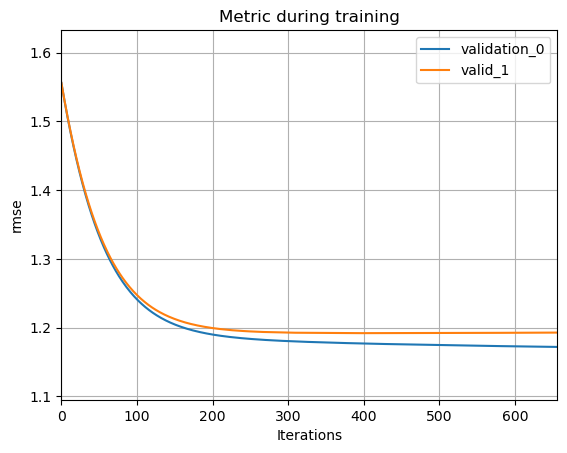

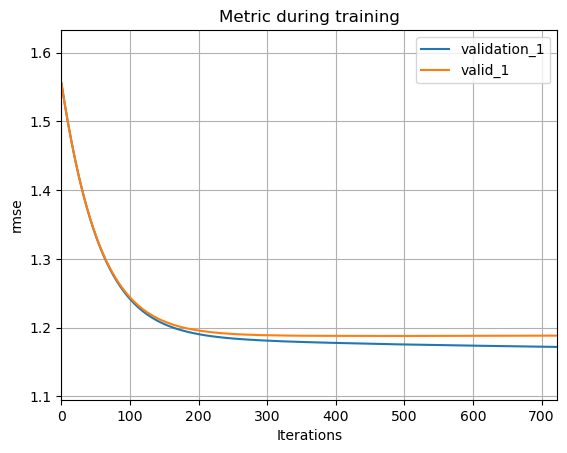

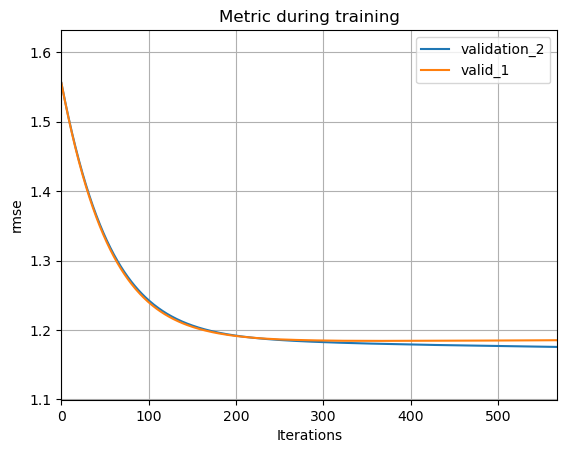

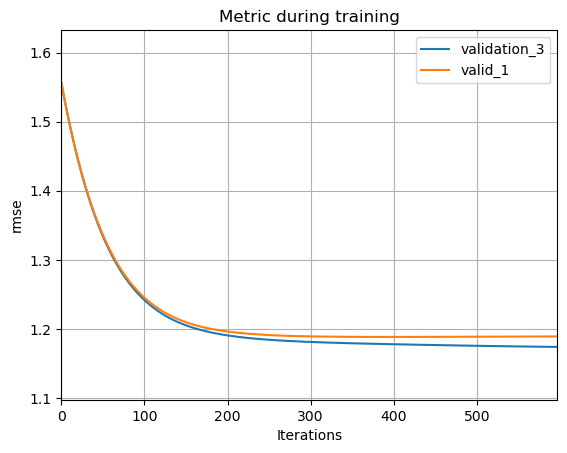

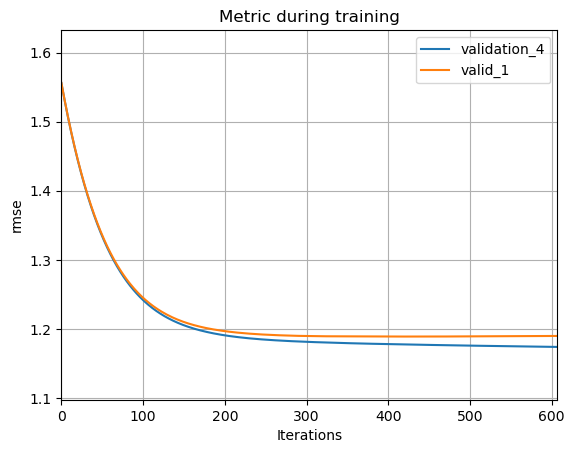

In [31]:
for evals in evals_results:
    lgb.plot_metric(evals, metric="rmse")

# Result

In [32]:
oof_score = root_mean_squared_error(y_true=target, y_pred=oof)
print(oof_score)

1.1882899799543782


### result distribution

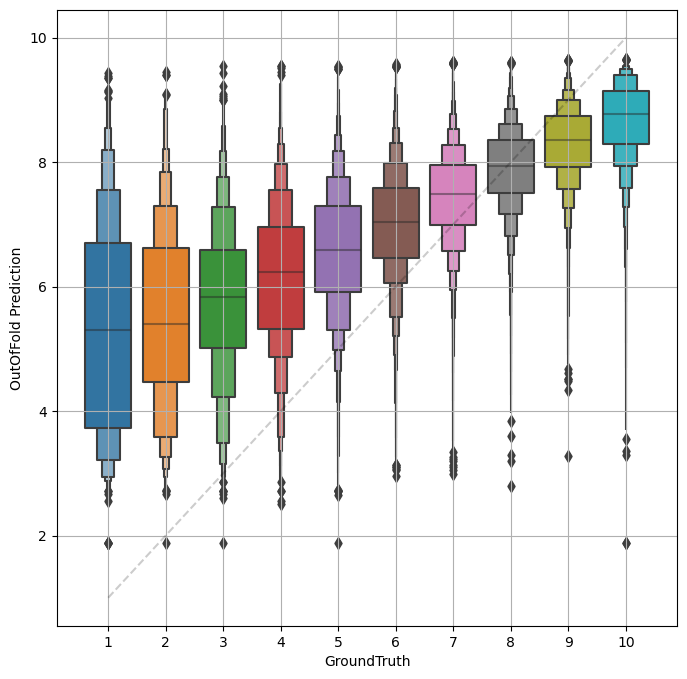

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.boxenplot(data=pd.DataFrame({ "GroundTruth": target, "OutOfFold Prediction": oof }), 
              x="GroundTruth", y="OutOfFold Prediction", ax=ax)

ax.grid()
ax.plot([0, 9], [1, 10], "--", c="black", alpha=.2)

### result importance

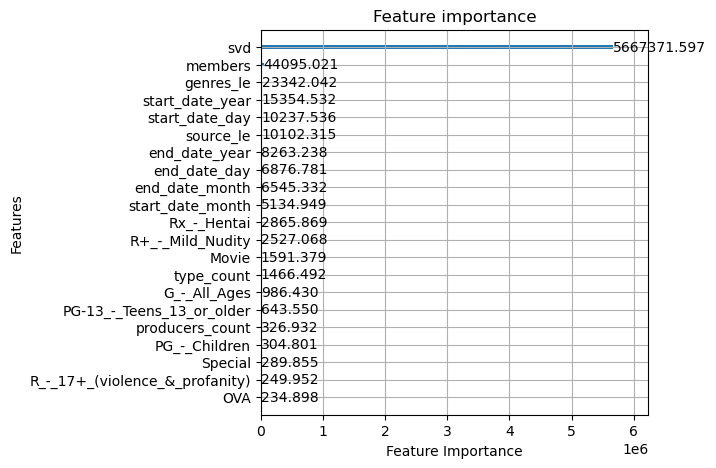

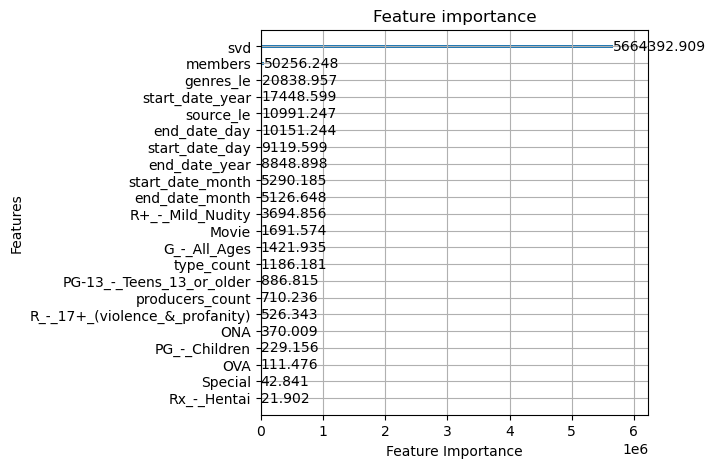

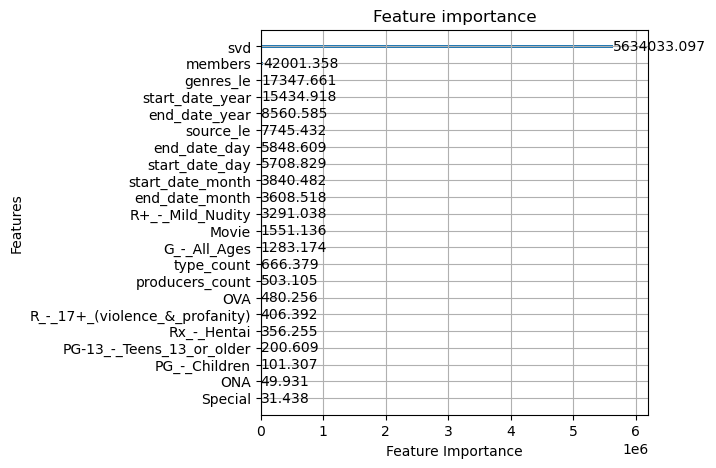

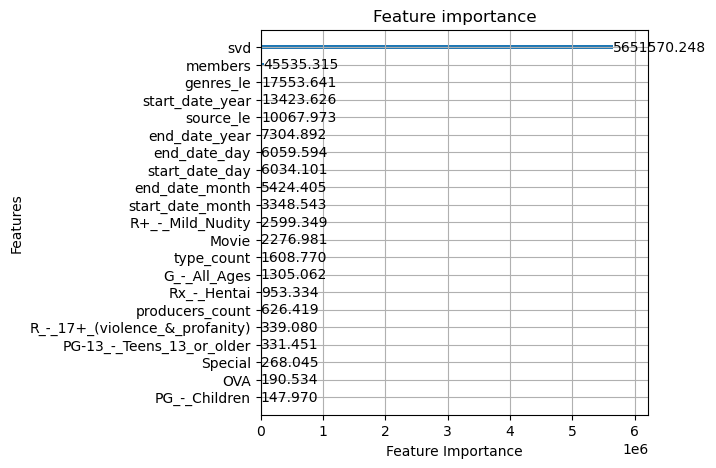

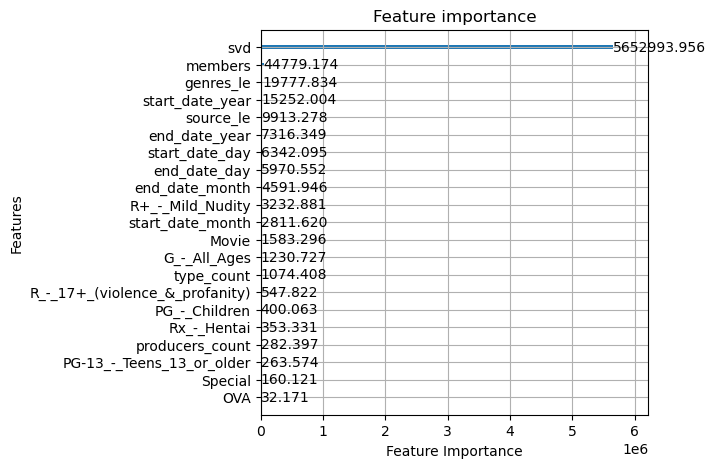

In [34]:
for idx, model in enumerate(models):
    lgb.plot_importance(model, figsize=(5,5),
                        importance_type="gain", max_num_features=25, 
                        xlabel="Feature Importance", ylabel="Features")

# Inference

['svd', 'members', 'tyoe_count', 'TV', 'Special', 'Movie', 'Unknown','ONA', 'OVA', 'Music']

In [35]:
input_columns = [col for col in input_df.columns if col not in ["fold", "score"]]
print(input_columns)
print(len(input_columns))

['svd', 'start_date_year', 'start_date_month', 'start_date_day', 'end_date_year', 'end_date_month', 'end_date_day', 'members', 'genres_le', 'source_le', 'type_count', 'studios_count', 'producers_count', 'anime_id_count', 'TV', 'Special', 'Movie', 'Unknown_type', 'ONA', 'OVA', 'Music', 'PG-13 - Teens 13 or older', 'R+ - Mild Nudity', 'R - 17+ (violence & profanity)', 'G - All Ages', 'PG - Children', 'Rx - Hentai', 'Unknown_rate']
28


In [36]:
test_df = pd.concat([test_df, test_feat_df], axis=1)
test_df = test_df[input_columns]

In [37]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test_df.values) for model in models])


# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0) # axis=0 なので shape の `k` が潰れる 

## Inference predictions

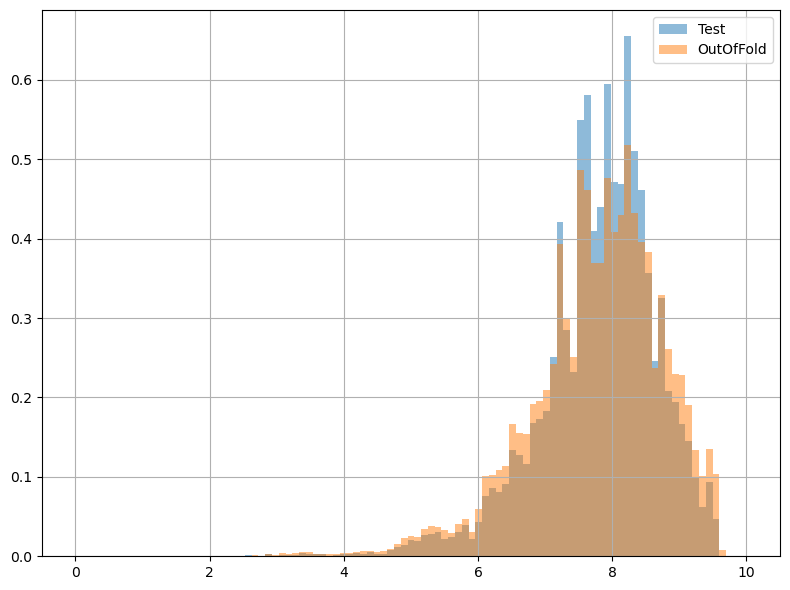

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 10, 100)
ax.hist(pred, bins=bins, density=True, alpha=.5, label="Test")
ax.hist(oof, bins=bins, density=True, alpha=.5, label="OutOfFold")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

# save infer csv

In [39]:
pd.DataFrame({
    "score": pred
}).to_csv(os.path.join(configs.OUTPUT_DIR, "submission.csv"), index=False)


In [40]:
oof_score

1.1882899799543782

In [41]:
if configs.wandb_available:
    wandb.log({"oof_score": oof_score})
    wandb.finish()